### Setup

In [1]:
import pandas as pd
import numpy as np
import os
from time import time

In [2]:
"""import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression, Lars
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
"""

'import numpy as np\nfrom sklearn.datasets import make_regression\nfrom sklearn.pipeline import make_pipeline,Pipeline\nfrom sklearn.linear_model import ElasticNetCV, LinearRegression, Lars\nfrom sklearn.svm import LinearSVR, SVR\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\nfrom sklearn.ensemble import GradientBoostingRegressor\nimport matplotlib.pyplot as plt\n'

In [3]:
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV

In [4]:
#import sys
#sys.path.append(os.path.abspath('..'))#sys.path[0] + '/..') 
from vb_estimators import LinRegSupreme
from vb_helper import VBHelper
from vb_cross_validator import regressor_q_stratified_cv

no daal4py


In [5]:

from warnings import filterwarnings
filterwarnings('ignore')


In [6]:
test_share=0#0.1
cv_folds=5
cv_reps=2
cv_count=cv_folds*cv_reps
rs=1 # random_state for reproducibility
vbhelper=VBHelper(test_share,cv_folds,cv_reps,cv_count,rs)

In [7]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
search_scorer='r2'
#cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
cv=regressor_q_stratified_cv(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs,group_count=20)

vbhelper.scorer_list=scorer_list
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

##### Example Dataset

In [8]:
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)
all_vars=list(df.columns)
print(all_vars)

['STA_ID', 'LONG', 'LAT', 'OrigHabCode', 'Date', 'THG_Fish', 'YEAR', 'SEASON', 'SUBAREA', 'HABCODE', 'Floc_Depth_ft', 'AFDW_Floc', 'MEHG_Floc', 'THG_floc', 'Tot_Phos_floc', 'Bulk_Dens_Floc', 'Soil_Thickness_FT', 'AFDW_Soil', 'Bulk_Dens_Soil', 'PH_soil', 'SO4_soil', 'MEHG_soil', 'THG_soil', 'Tot_Carbon_Soil_%', 'Tot_Nitrogen_Soil_%', 'Tot_Phos_soil', 'Wat_Depth_ft', 'COND_SW', 'DO_SW', 'TEMP_SW', 'PH_SW', 'TURB_SW', 'REDOX_SW', 'Alk_Phos_SW', 'CHLA_SW', 'CL_SW', 'MEHG_SW', 'NH4_SW', 'NO2_SW', 'NO3_SW', 'SO4_SW', 'Sol_Reac_Phos_SW', 'THG_SW', 'TOC_SW', 'Tot_Nitrogen_SW', 'Tot_Phos_SW', 'REDOX_PW', 'H2S_PW', 'Sol_Reac_Phos_PW', 'MEHG_Peri_AVG', 'THG_epi_peri']


In [9]:
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
x_vars=[var for var in all_vars if var not in drop_vars]
X_df=df.loc[:,x_vars]
y_df=df.loc[:,y_name]

In [10]:
if test_share:
     X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_share, random_state=rs)
else:
    X_train, X_test, y_train, y_test = (X_df, None, y_df, None)

In [11]:
if 1:
    start=time()
    test2=LinRegSupreme().fit(X_train,y_train)
    print(test2.score(X_train,y_train))
    #test2.score(X_test,y_test)
    end=time()
    print(f'runtime:{(end-start)/60} min.')

0.582610268516369
runtime:1.3414257089296977 min.


In [12]:
estimator_dict={
    'lin-reg-supreme':LinRegSupreme,
    #'elastic-net':elastic_net_cv, 
    #'linear-svr-cv':linear_svr_cv, 
    #'rbf-svr-cv':rbf_svr_cv, 
    #'gradient-boosting-reg':gradient_boosting_reg
   }
vbhelper.estimator_dict=estimator_dict
model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [13]:
"""i=0
for name,est in model_dict.items():
    i+=1;print(name)
    est.fit(X_train,y_train)
    print(est.score(X_test,y_test))
"""

'i=0\nfor name,est in model_dict.items():\n    i+=1;print(name)\n    est.fit(X_train,y_train)\n    print(est.score(X_test,y_test))\n'

In [14]:
cv_results={}
for estimator_name,model in model_dict.items():
    start=time()
    model_i=cross_validate(model, X_train, y_train, return_estimator=True, scoring=scorer_list, cv=cv, n_jobs=10)
    end=time()
    print(f"{estimator_name},{[(scorer,np.mean(model_i[f'test_{scorer}'])) for scorer in scorer_list]}, runtime:{(end-start)/60} min.")
    cv_results[estimator_name]=model_i
            
# replace with a loop in order to save the residuals for a graph?

lin-reg-supreme,[('neg_mean_squared_error', nan), ('neg_mean_absolute_error', nan), ('r2', nan)], runtime:10.81887863477071 min.


#### graphs and table to summarize results

In [15]:
cv_score_dict={}
cv_score_dict_means={}
for idx,(estimator_name,result) in enumerate(cv_results.items()):
    #cv_estimators=result['estimator']
    model_idx_scoredict={scorer:result[f'test_{scorer}'] for scorer in scorer_list}# fstring bc how cross_validate stores list of metrics
    cv_score_dict[estimator_name]=model_idx_scoredict 
    model_idx_mean_scores={scorer:np.mean(scores) for scorer,scores in model_idx_scoredict.items()}
    cv_score_dict_means[estimator_name]=model_idx_mean_scores

In [16]:
for scorer in scorer_list:
    print(f'scores for scorer: {scorer}:')
    for estimator_name in model_dict:
        print(f'    {estimator_name}:{cv_score_dict_means[estimator_name][scorer]}')

scores for scorer: neg_mean_squared_error:
    lin-reg-supreme:nan
scores for scorer: neg_mean_absolute_error:
    lin-reg-supreme:nan
scores for scorer: r2:
    lin-reg-supreme:nan


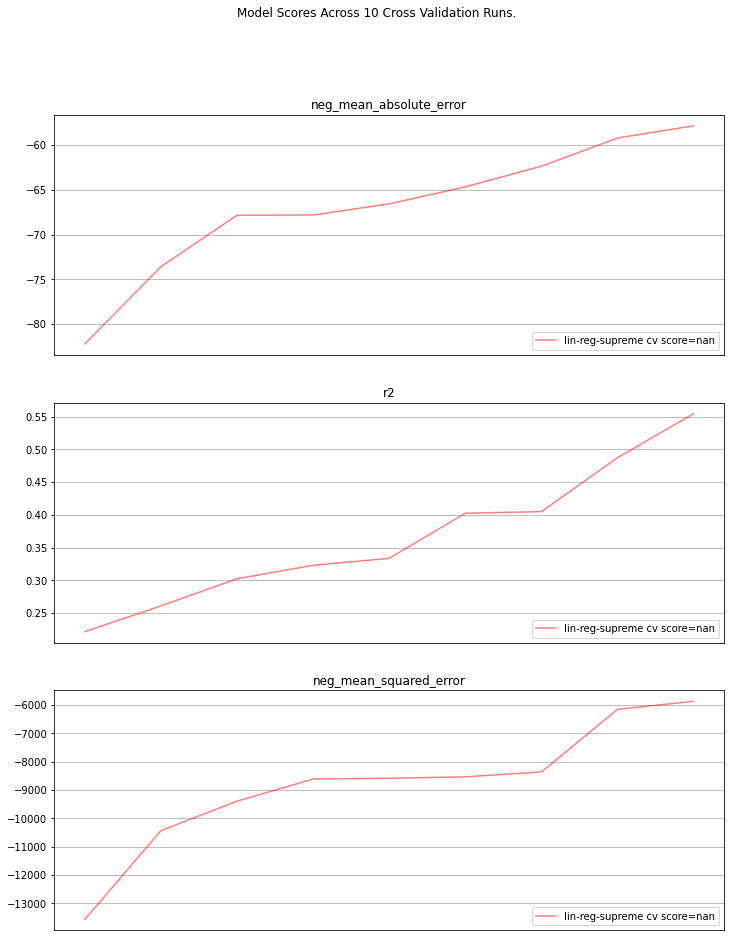

In [17]:
vbhelper.plotCVScores(cv_score_dict,sort=1)

In [18]:
# create a similar plot showing residuals from the cv models for each value of y. 
# needs to be scatterplot or histogram since there will be (folds-1)*repeats predictions of each value of y.

-----------------------------
### User chooses Linear Regression with LARS variable selection!


In [19]:
final_estimator_name='linear-regression-lars'

In [20]:
def printTestandCVScores(estimator_name,cv_score_dict_means):
    model=estimator_dict[estimator_name]()
    model.fit(X_train,y_train)
    if test_share:
        y_test_hat=model.predict(X_test)
        print(f'test set: negative-mse={-mean_squared_error(y_test,y_test_hat)}')
    for scorer in scorer_list:
        print(f'cv avg: {scorer}= {cv_score_dict_means[estimator_name][scorer]}')
    try:
        print('coefficients: ',model[-1].coef_)
        print('intercept: ',model[-1].intercept_)
        #print('\n','original positions: ',model[-2].col_select)
    except:
        pass

In [21]:
for name in estimator_dict.keys():
    print(name)
    printTestandCVScores(name,cv_score_dict_means)

lin-reg-supreme
cv avg: neg_mean_squared_error= nan
cv avg: neg_mean_absolute_error= nan
cv avg: r2= nan


In [22]:
printTestandCVScores('elastic-net',cv_score_dict_means)
# fits better but soooo many coefficients

KeyError: 'elastic-net'

In [ ]:
printTestandCVScores('lin_reg_Xy_transform',cv_score_dict_means)